# Detailed Q-Learning Implementation with Agent Movement Visualization

This notebook provides a detailed implementation of Q-learning with visualizations to observe agent movement step-by-step in a grid world environment.

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import time
from IPython.display import clear_output
from matplotlib.patches import Rectangle, Arrow
import matplotlib.animation as animation
from IPython.display import HTML

## 2. Create Grid World Environment

We'll create a simple grid world where:
- The agent starts at a specified position
- There are obstacles that the agent must avoid
- There is a goal state that the agent must reach

In [2]:
class GridWorldEnv:
    def __init__(self, height=5, width=5):
        self.height = height
        self.width = width
        self.n_states = height * width
        self.n_actions = 4  # up, right, down, left
        
        # Define obstacles (represented as -1) and goal state (10)
        self.grid = np.zeros((height, width))
        self.obstacles = [(1, 1), (1, 2), (2, 1), (3, 3)]
        self.goal_state = (4, 4)
        
        # Set obstacles and goal in the grid
        for obs in self.obstacles:
            self.grid[obs] = -1
        self.grid[self.goal_state] = 10
        
        # Starting position
        self.start_state = (0, 0)
        self.current_state = self.start_state
        
        # Define action mappings
        self.actions = {
            0: (-1, 0),  # up
            1: (0, 1),   # right
            2: (1, 0),   # down
            3: (0, -1)   # left
        }
        
        # History to store all states visited
        self.history = []
    
    def reset(self):
        self.current_state = self.start_state
        self.history = [self.current_state]
        return self.current_state
    
    def step(self, action):
        # Get the direction from the action
        direction = self.actions[action]
        
        # Calculate new state
        new_row = self.current_state[0] + direction[0]
        new_col = self.current_state[1] + direction[1]
        new_state = (new_row, new_col)
        
        # Check if new state is valid
        if self._is_valid_state(new_state):
            self.current_state = new_state
        
        # Add to history
        self.history.append(self.current_state)
        
        # Calculate reward and check if done
        if self.current_state == self.goal_state:
            reward = 10
            done = True
        elif self.current_state in self.obstacles:
            reward = -10
            done = True
        else:
            reward = -1  # Small negative reward to encourage finding goal faster
            done = False
        
        return self.current_state, reward, done
    
    def _is_valid_state(self, state):
        row, col = state
        # Check if state is within grid boundaries
        if 0 <= row < self.height and 0 <= col < self.width:
            return True
        return False
    
    def render(self, q_table=None, show_history=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Create a colormap for the grid
        cmap = mcolors.ListedColormap(['white', 'red', 'green'])
        bounds = [-2, -0.5, 0.5, 11]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Draw the grid
        ax.imshow(self.grid, cmap=cmap, norm=norm)
        
        # Draw grid lines
        for i in range(self.width + 1):
            ax.axvline(i - 0.5, color='black', linewidth=1)
        for i in range(self.height + 1):
            ax.axhline(i - 0.5, color='black', linewidth=1)
        
        # Mark obstacles and goal
        for obs in self.obstacles:
            ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1, fill=True, color='red', alpha=0.5))
        ax.add_patch(Rectangle((self.goal_state[1] - 0.5, self.goal_state[0] - 0.5), 1, 1, fill=True, color='green', alpha=0.5))
        
        # Highlight current position
        ax.add_patch(Rectangle((self.current_state[1] - 0.5, self.current_state[0] - 0.5), 1, 1, fill=True, color='blue', alpha=0.3))
        
        # Show history of positions if requested
        if show_history and len(self.history) > 1:
            history_y = [state[0] for state in self.history]
            history_x = [state[1] for state in self.history]
            ax.plot(history_x, history_y, 'o-', color='purple', markersize=8, alpha=0.6)
        
        # Show Q-values as arrows if provided
        if q_table is not None:
            self._draw_policy_arrows(ax, q_table)
        
        # Set labels and title
        ax.set_xticks(np.arange(self.width))
        ax.set_yticks(np.arange(self.height))
        ax.set_xticklabels(np.arange(self.width))
        ax.set_yticklabels(np.arange(self.height))
        ax.set_title('Grid World')
        plt.show()
    
    def _draw_policy_arrows(self, ax, q_table):
        # Draw arrows for each state based on the highest Q-value action
        for i in range(self.height):
            for j in range(self.width):
                if (i, j) not in self.obstacles and (i, j) != self.goal_state:
                    state_idx = i * self.width + j
                    if np.any(q_table[state_idx] != 0):  # Only show arrows for explored states
                        action = np.argmax(q_table[state_idx])
                        dx, dy = self.actions[action]
                        # Flip for plotting (matplotlib y-axis is inverted)
                        dx, dy = dy, -dx
                        ax.arrow(j, i, dx * 0.3, dy * 0.3, head_width=0.15, head_length=0.15, fc='black', ec='black')
        
    def animate_episode(self, history):
        # For animation of an entire episode
        fig, ax = plt.subplots(figsize=(8, 8))
        
        def update(frame):
            ax.clear()
            
            # Draw the grid
            cmap = mcolors.ListedColormap(['white', 'red', 'green'])
            bounds = [-2, -0.5, 0.5, 11]
            norm = mcolors.BoundaryNorm(bounds, cmap.N)
            ax.imshow(self.grid, cmap=cmap, norm=norm)
            
            # Draw grid lines
            for i in range(self.width + 1):
                ax.axvline(i - 0.5, color='black', linewidth=1)
            for i in range(self.height + 1):
                ax.axhline(i - 0.5, color='black', linewidth=1)
            
            # Mark obstacles and goal
            for obs in self.obstacles:
                ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1, fill=True, color='red', alpha=0.5))
            ax.add_patch(Rectangle((self.goal_state[1] - 0.5, self.goal_state[0] - 0.5), 1, 1, fill=True, color='green', alpha=0.5))
            
            # Highlight current position for this frame
            if frame < len(history):
                current_pos = history[frame]
                ax.add_patch(Rectangle((current_pos[1] - 0.5, current_pos[0] - 0.5), 1, 1, fill=True, color='blue', alpha=0.6))
                
                # Show path up to this point
                if frame > 0:
                    path_y = [state[0] for state in history[:frame+1]]
                    path_x = [state[1] for state in history[:frame+1]]
                    ax.plot(path_x, path_y, 'o-', color='purple', markersize=5, alpha=0.6)
            
            # Set labels and title
            ax.set_xticks(np.arange(self.width))
            ax.set_yticks(np.arange(self.height))
            ax.set_xticklabels(np.arange(self.width))
            ax.set_yticklabels(np.arange(self.height))
            ax.set_title(f'Agent Movement - Step {frame}')
        
        anim = animation.FuncAnimation(fig, update, frames=len(history), interval=500)
        return HTML(anim.to_jshtml())

## 3. Implement Q-Learning Algorithm

Now we'll implement the Q-learning algorithm that will allow our agent to learn optimal policies for navigating the grid world.

In [3]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, min_exploration_rate=0.01, exploration_decay=0.995):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.min_epsilon = min_exploration_rate
        self.epsilon_decay = exploration_decay
        
        # Initialize Q-table with zeros
        self.q_table = np.zeros((n_states, n_actions))
        
        # Store episode data for visualization
        self.episode_data = []
    
    def choose_action(self, state, row_col=True):
        # Convert row, col state to flat index if needed
        if row_col:
            state_idx = state[0] * 5 + state[1]  # Assuming 5x5 grid
        else:
            state_idx = state
        
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            # Explore: choose a random action
            action = random.randint(0, self.n_actions - 1)
        else:
            # Exploit: choose the best action based on Q-values
            action = np.argmax(self.q_table[state_idx])
        
        return action
    
    def update(self, state, action, reward, next_state, done, row_col=True):
        # Convert states to flat indices if needed
        if row_col:
            state_idx = state[0] * 5 + state[1]  # Assuming 5x5 grid
            next_state_idx = next_state[0] * 5 + next_state[1]
        else:
            state_idx = state
            next_state_idx = next_state
        
        # Current Q-value
        current_q = self.q_table[state_idx, action]
        
        # Q-learning update rule
        if done:
            # If terminal state, there is no future reward
            target_q = reward
        else:
            # Calculate target using Bellman equation
            max_next_q = np.max(self.q_table[next_state_idx])
            target_q = reward + self.gamma * max_next_q
        
        # Update Q-value with learning rate
        self.q_table[state_idx, action] += self.lr * (target_q - current_q)
        
        # Store update data for visualization
        update_data = {
            'state': state,
            'action': action,
            'reward': reward,
            'next_state': next_state,
            'current_q': current_q,
            'target_q': target_q,
            'new_q': self.q_table[state_idx, action]
        }
        self.episode_data.append(update_data)
    
    def decay_exploration(self):
        # Decay exploration rate after each episode
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
    
    def reset_episode_data(self):
        self.episode_data = []

## 4. Train the Agent and Visualize Movement

Now we'll train our Q-learning agent and observe its movement in detail.

In [4]:
# Create environment and agent
env = GridWorldEnv(height=5, width=5)
agent = QLearningAgent(n_states=env.n_states, n_actions=env.n_actions)

# Training parameters
n_episodes = 500
max_steps = 100

# Lists to store metrics
episode_rewards = []
episode_steps = []
all_episode_histories = []

# Training loop
for episode in range(n_episodes):
    # Reset environment and agent episode data
    state = env.reset()
    agent.reset_episode_data()
    
    total_reward = 0
    done = False
    steps = 0
    
    # Episode loop
    while not done and steps < max_steps:
        # Choose an action
        action = agent.choose_action(state)
        
        # Take the action
        next_state, reward, done = env.step(action)
        
        # Update Q-values
        agent.update(state, action, reward, next_state, done)
        
        # Update state and counters
        state = next_state
        total_reward += reward
        steps += 1
    
    # Decay exploration rate
    agent.decay_exploration()
    
    # Store episode metrics
    episode_rewards.append(total_reward)
    episode_steps.append(steps)
    all_episode_histories.append(env.history.copy())
    
    # Print progress occasionally
    if episode % 50 == 0 or episode == n_episodes - 1:
        print(f"Episode {episode}: Reward = {total_reward}, Steps = {steps}, Epsilon = {agent.epsilon:.4f}")

print("Training complete!")

Episode 0: Reward = -11, Steps = 2, Epsilon = 0.9950
Episode 50: Reward = -23, Steps = 14, Epsilon = 0.7744
Episode 100: Reward = -15, Steps = 6, Epsilon = 0.6027
Episode 150: Reward = -20, Steps = 11, Epsilon = 0.4691
Episode 200: Reward = -18, Steps = 9, Epsilon = 0.3651
Episode 250: Reward = 2, Steps = 9, Epsilon = 0.2842
Episode 300: Reward = 3, Steps = 8, Epsilon = 0.2212
Episode 350: Reward = 1, Steps = 10, Epsilon = 0.1721
Episode 400: Reward = 3, Steps = 8, Epsilon = 0.1340
Episode 450: Reward = 3, Steps = 8, Epsilon = 0.1043
Episode 499: Reward = 2, Steps = 9, Epsilon = 0.0816
Training complete!


## 5. Visualize Learning Progress

Let's visualize how the agent's performance improved over time.

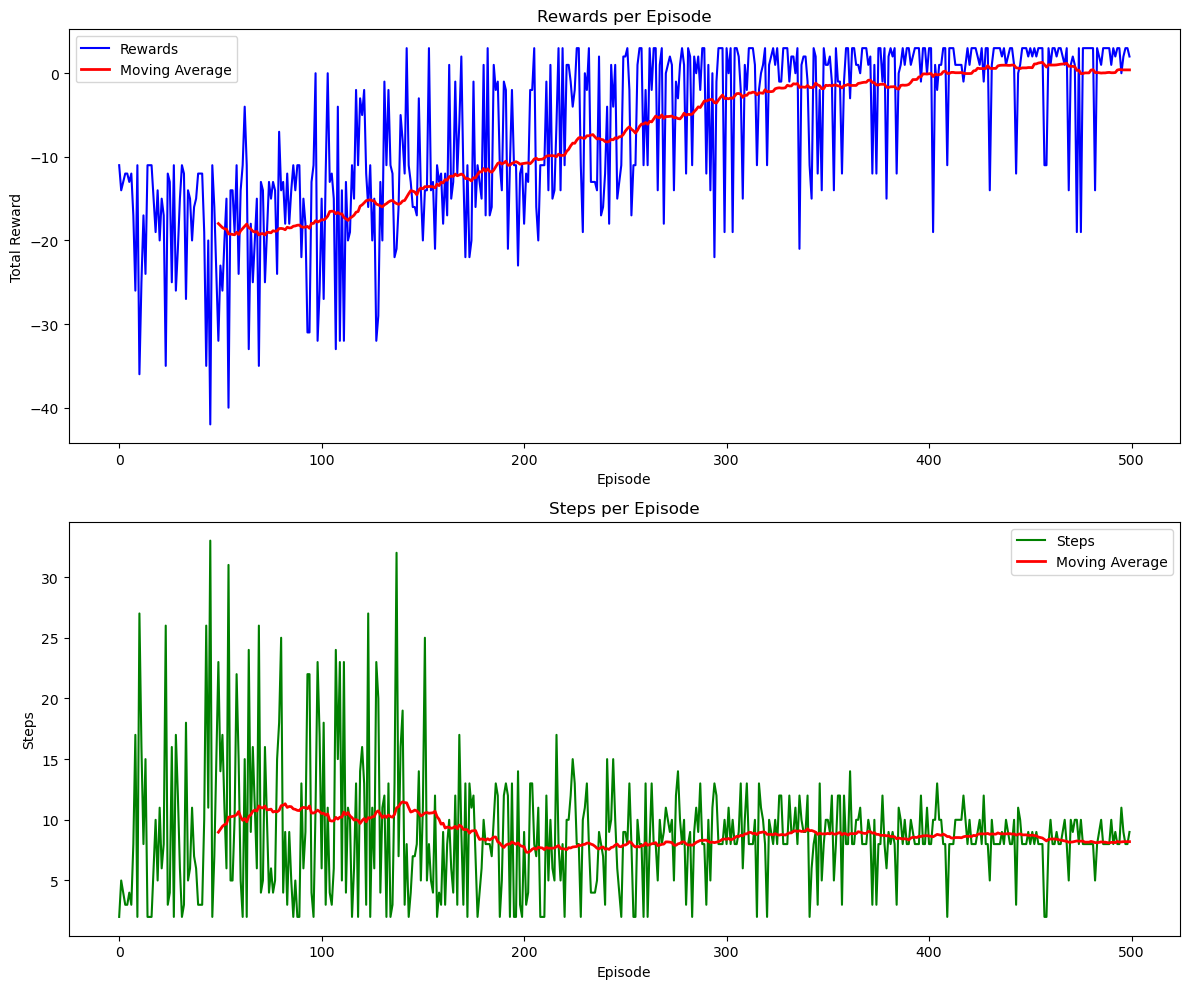

In [5]:
# Plot reward and steps per episode
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot rewards
ax1.plot(episode_rewards, 'b-')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Rewards per Episode')
# Add smoothed line for trend
window_size = 50
if n_episodes >= window_size:
    smoothed_rewards = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(range(window_size-1, len(episode_rewards)), smoothed_rewards, 'r-', linewidth=2)
    ax1.legend(['Rewards', 'Moving Average'])

# Plot steps
ax2.plot(episode_steps, 'g-')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps')
ax2.set_title('Steps per Episode')
# Add smoothed line for trend
if n_episodes >= window_size:
    smoothed_steps = np.convolve(episode_steps, np.ones(window_size)/window_size, mode='valid')
    ax2.plot(range(window_size-1, len(episode_steps)), smoothed_steps, 'r-', linewidth=2)
    ax2.legend(['Steps', 'Moving Average'])

plt.tight_layout()
plt.show()

## 6. Visualize the Final Policy

Let's visualize the learned policy using arrows to indicate the best action in each state.

Final Policy:


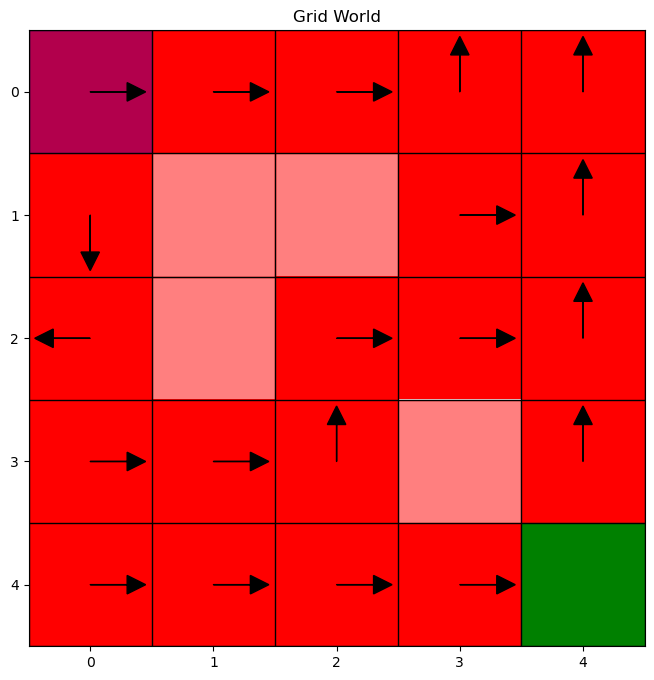


Q-Table:
State (0,0): [-2.43647877 -0.43407762 -3.73154202 -2.29266255]
State (0,1): [-1.38965241  0.62881527 -9.96242898 -2.38154891]
State (0,2): [-0.44743316  1.80979873 -9.85219117 -2.12988905]
State (0,3): [ 0.6587718   0.28654853  3.12199972 -0.1924514 ]
State (0,4): [-1.48023981 -0.97105389  3.87222013 -1.40184601]
State (1,0): [-2.55033931 -9.774716   -3.24747861 -3.28616315]
State (1,1): [0. 0. 0. 0.]
State (1,2): [0. 0. 0. 0.]
State (1,3): [ 0.71386525  4.57999995  2.79458234 -9.20233557]
State (1,4): [0.45945659 2.36603932 6.19999999 0.62517592]
State (2,0): [-3.00714188 -9.41850263 -2.61415536 -2.60398707]
State (2,1): [0. 0. 0. 0.]
State (2,2): [-1.9        -0.04307146 -0.5301803  -1.9       ]
State (2,3): [-0.46746524  5.99485399 -4.0951     -0.51874846]
State (2,4): [3.16214172 4.23569047 8.         2.92542639]
State (3,0): [-2.33524834 -1.91480667 -1.93516909 -1.98678631]
State (3,1): [-7.45813417 -1.02265932 -1.19203672 -1.27538401]
State (3,2): [-0.83975216 -5.217031

In [6]:
# Reset the environment and render with the learned Q-table
env.reset()
print("Final Policy:")
env.render(q_table=agent.q_table)

# Print the Q-table in a readable format
print("\nQ-Table:")
for i in range(env.height):
    for j in range(env.width):
        state_idx = i * env.width + j
        print(f"State ({i},{j}): {agent.q_table[state_idx]}")

## 7. Detailed Movement Visualization

Now let's observe the agent's movement in detail by running a test episode and visualizing each step.

Starting a test episode...
Step 1: At state (0, 0), taking action Right, moved to (0, 1), reward: -1


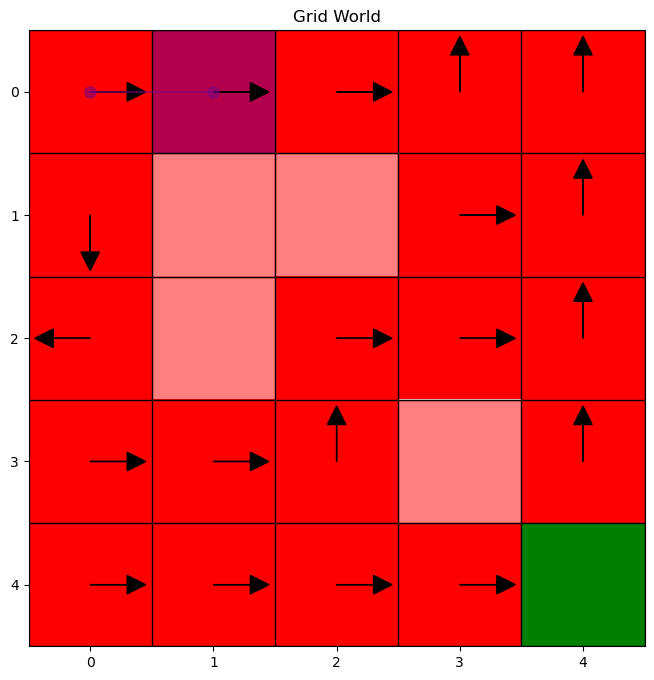

Step 2: At state (0, 1), taking action Right, moved to (0, 2), reward: -1


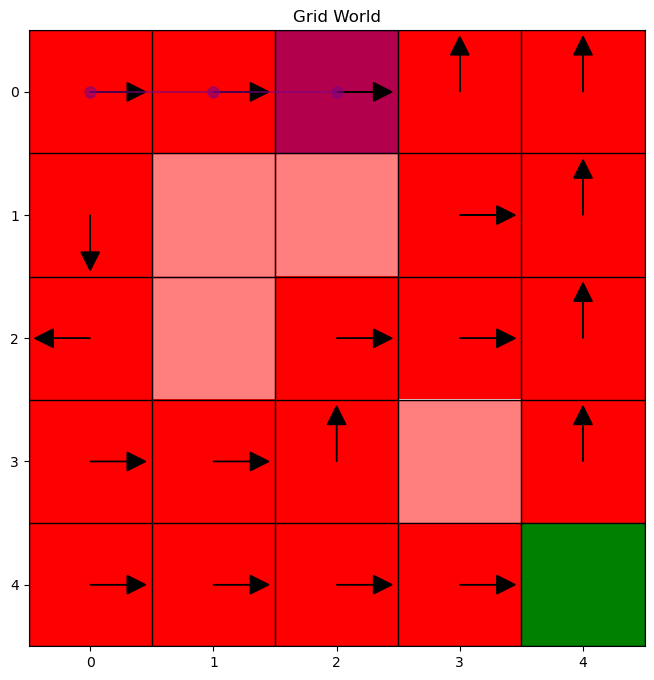

Step 3: At state (0, 2), taking action Right, moved to (0, 3), reward: -1


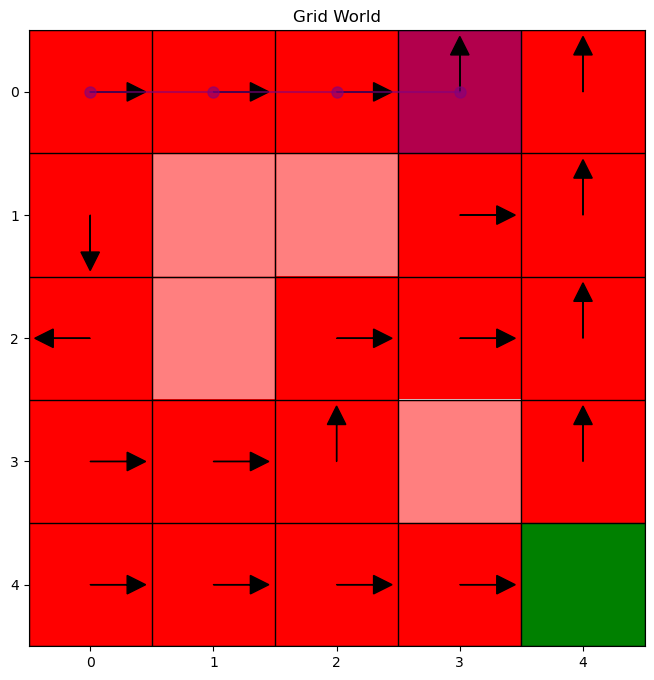

Step 4: At state (0, 3), taking action Down, moved to (1, 3), reward: -1


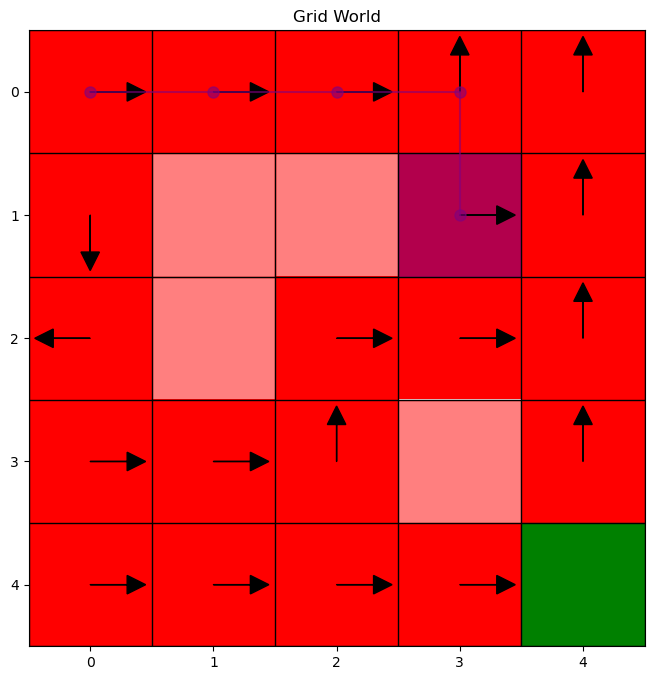

Step 5: At state (1, 3), taking action Right, moved to (1, 4), reward: -1


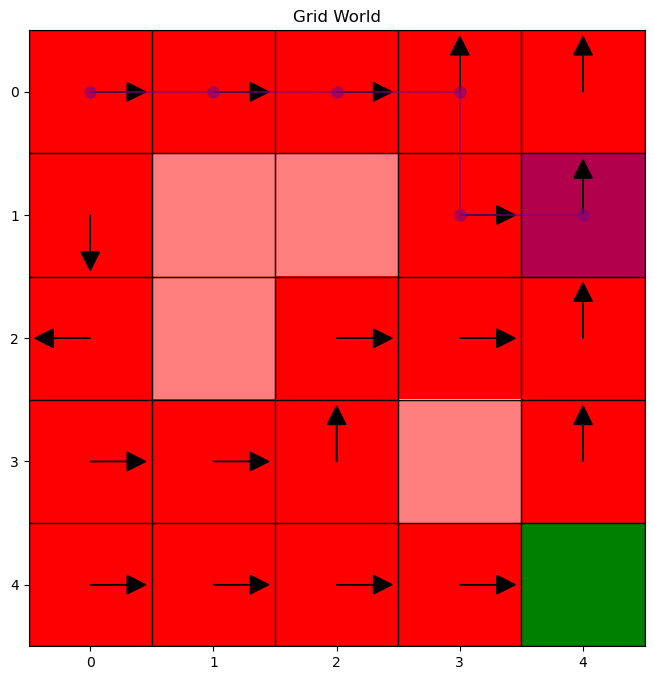

Step 6: At state (1, 4), taking action Down, moved to (2, 4), reward: -1


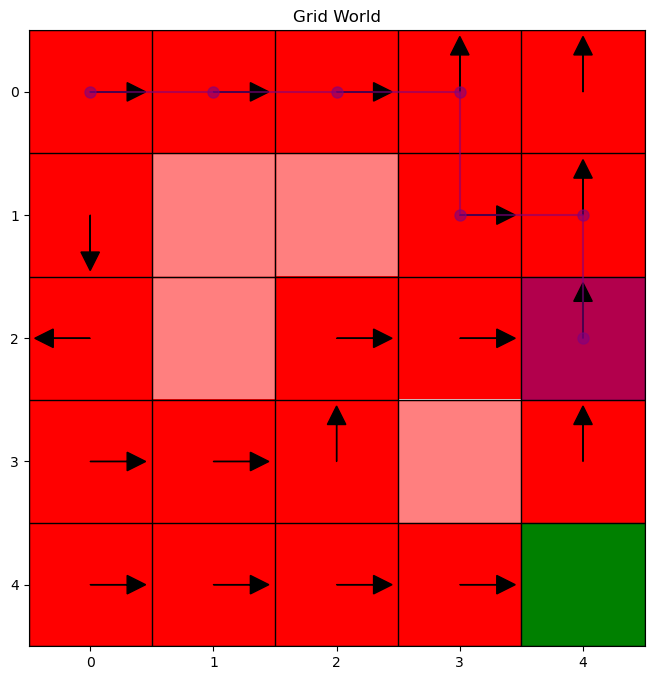

Step 7: At state (2, 4), taking action Down, moved to (3, 4), reward: -1


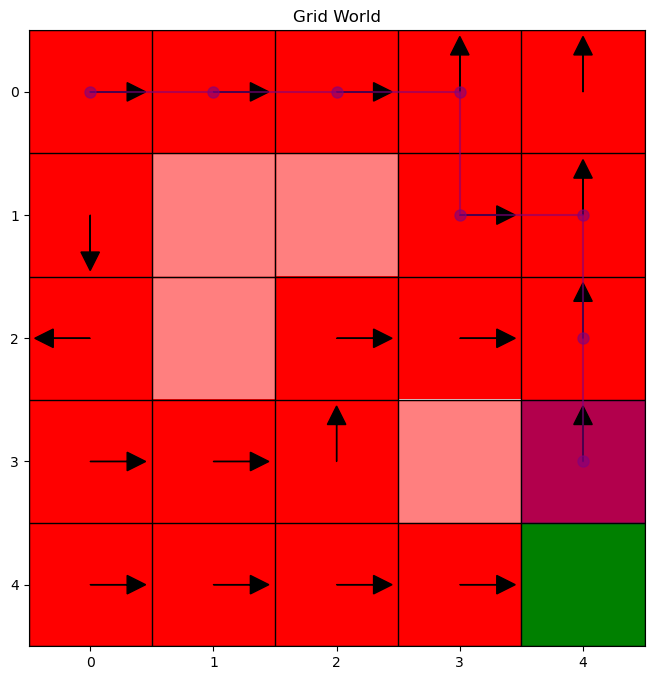

Step 8: At state (3, 4), taking action Down, moved to (4, 4), reward: 10


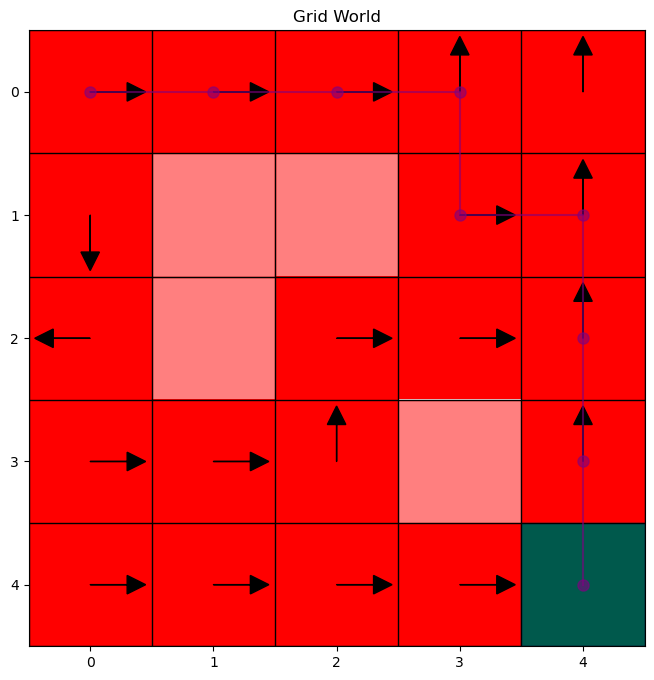


Test episode complete! Total steps: 8, Total reward: 3


In [7]:
# Run a test episode with no exploration (fully exploit the learned policy)
original_epsilon = agent.epsilon
agent.epsilon = 0  # No exploration, just follow the learned policy

# Reset environment
state = env.reset()
done = False
steps = 0
total_reward = 0

print("Starting a test episode...")

# Run episode
while not done and steps < max_steps:
    # Choose action based on learned policy
    action = agent.choose_action(state)
    
    # Take action
    next_state, reward, done = env.step(action)
    
    # Display the action and current state
    action_names = ["Up", "Right", "Down", "Left"]
    print(f"Step {steps+1}: At state {state}, taking action {action_names[action]}, moved to {next_state}, reward: {reward}")
    
    # Visualize
    env.render(q_table=agent.q_table, show_history=True)
    
    # Update state and counters
    state = next_state
    total_reward += reward
    steps += 1

print(f"\nTest episode complete! Total steps: {steps}, Total reward: {total_reward}")

# Restore original epsilon
agent.epsilon = original_epsilon

## 8. Agent Movement Animation

Let's create an animation of the agent's movement to better visualize its journey.

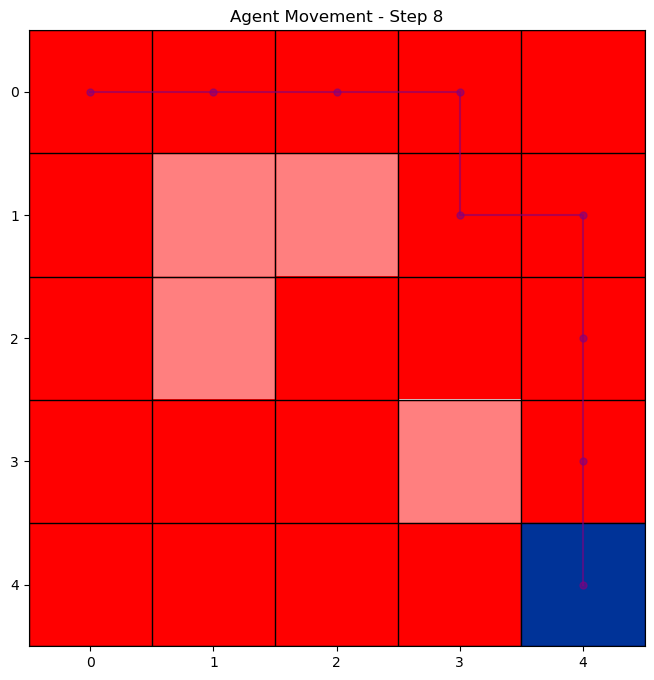

In [8]:
# We'll animate the most recent test episode
animation_result = env.animate_episode(env.history)
animation_result

## 9. Compare Different Learning Phases

Let's compare the agent's movement and decision-making during different phases of learning.

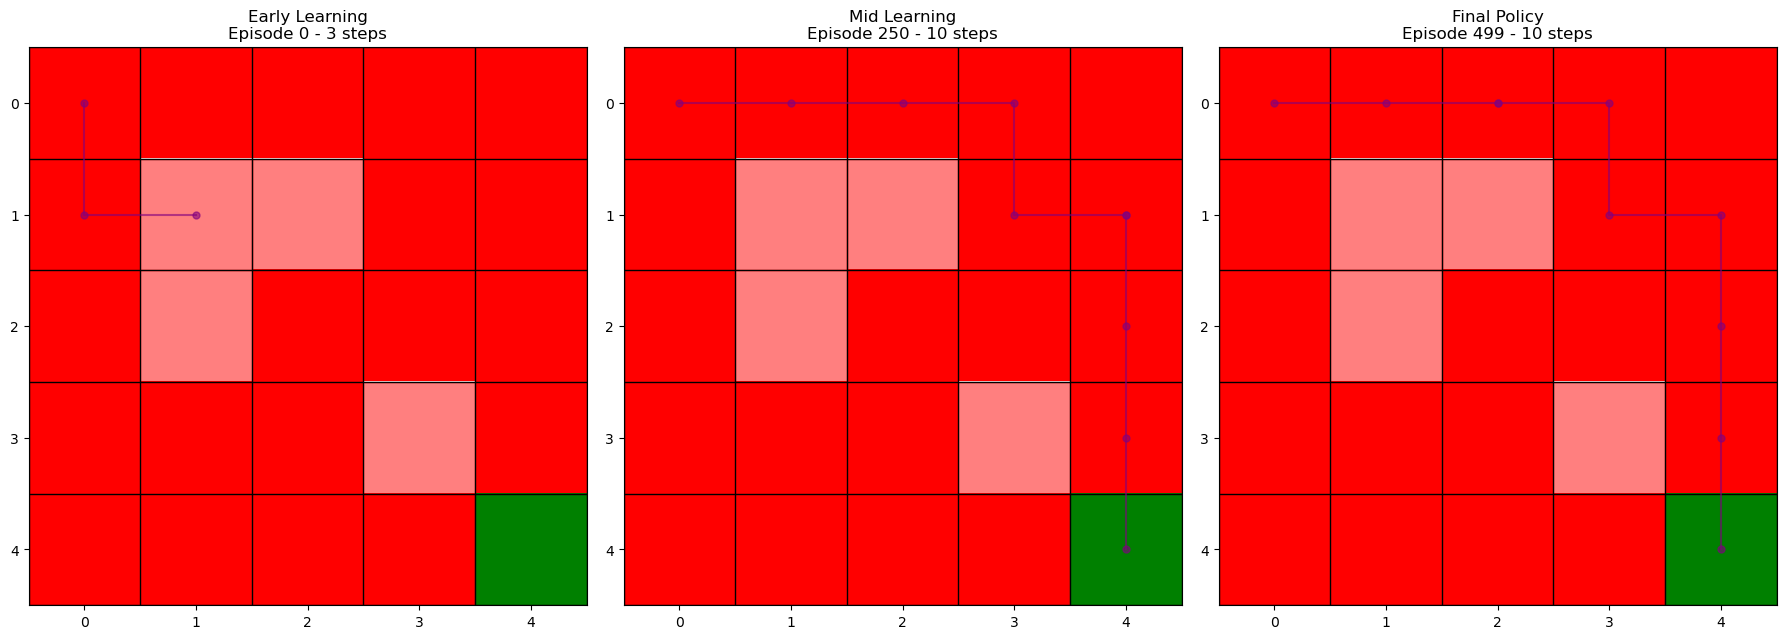

In [9]:
# Compare early, mid, and late learning episodes
episodes_to_compare = [0, n_episodes // 2, n_episodes - 1]
labels = ['Early Learning', 'Mid Learning', 'Final Policy']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (ep_idx, label) in enumerate(zip(episodes_to_compare, labels)):
    ax = axes[i]
    history = all_episode_histories[ep_idx]
    
    # Draw the grid
    cmap = mcolors.ListedColormap(['white', 'red', 'green'])
    bounds = [-2, -0.5, 0.5, 11]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    ax.imshow(env.grid, cmap=cmap, norm=norm)
    
    # Draw grid lines
    for j in range(env.width + 1):
        ax.axvline(j - 0.5, color='black', linewidth=1)
    for j in range(env.height + 1):
        ax.axhline(j - 0.5, color='black', linewidth=1)
    
    # Mark obstacles and goal
    for obs in env.obstacles:
        ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1, fill=True, color='red', alpha=0.5))
    ax.add_patch(Rectangle((env.goal_state[1] - 0.5, env.goal_state[0] - 0.5), 1, 1, fill=True, color='green', alpha=0.5))
    
    # Show path
    if len(history) > 1:
        path_y = [state[0] for state in history]
        path_x = [state[1] for state in history]
        ax.plot(path_x, path_y, 'o-', color='purple', markersize=5, alpha=0.6)
    
    # Set labels and title
    ax.set_xticks(np.arange(env.width))
    ax.set_yticks(np.arange(env.height))
    ax.set_xticklabels(np.arange(env.width))
    ax.set_yticklabels(np.arange(env.height))
    ax.set_title(f"{label}\nEpisode {ep_idx} - {len(history)} steps")

plt.tight_layout()
plt.show()

## 10. Analyze Q-Values in Detail

Let's examine the Q-values for specific states to understand the agent's decision-making process.

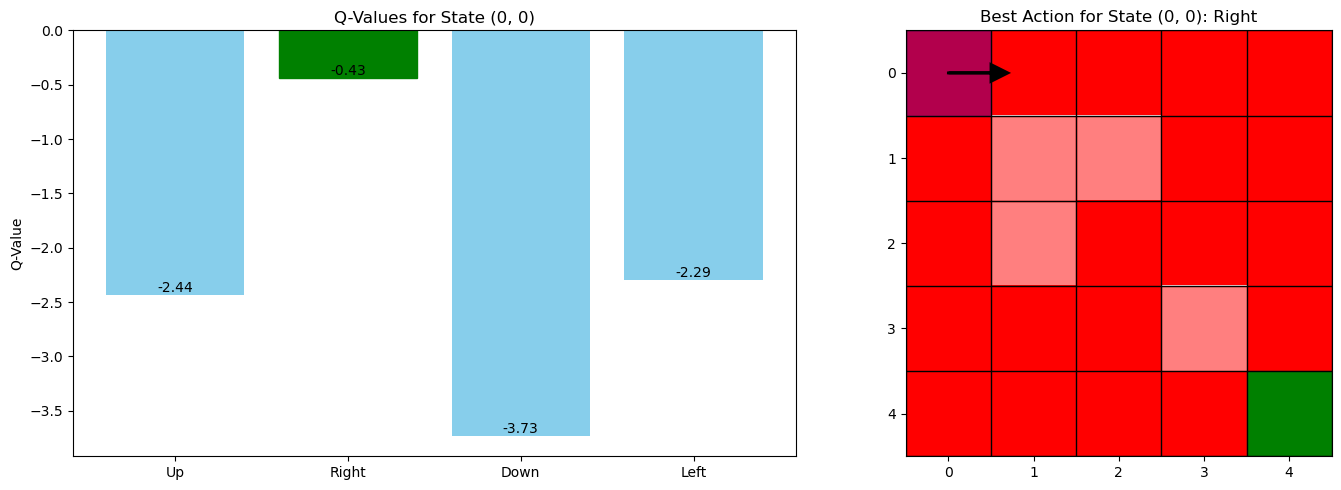

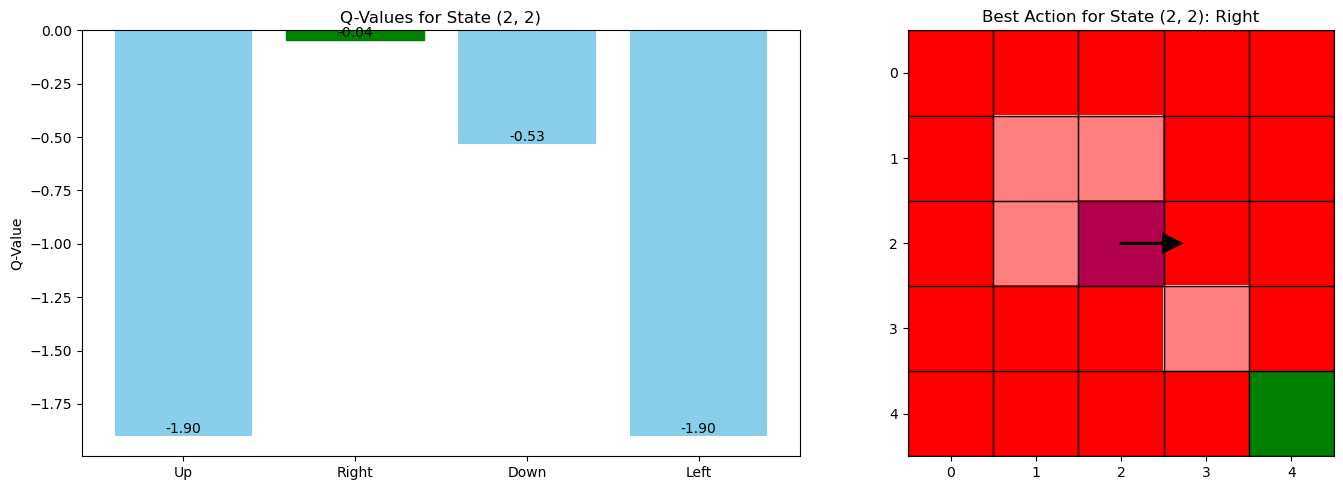

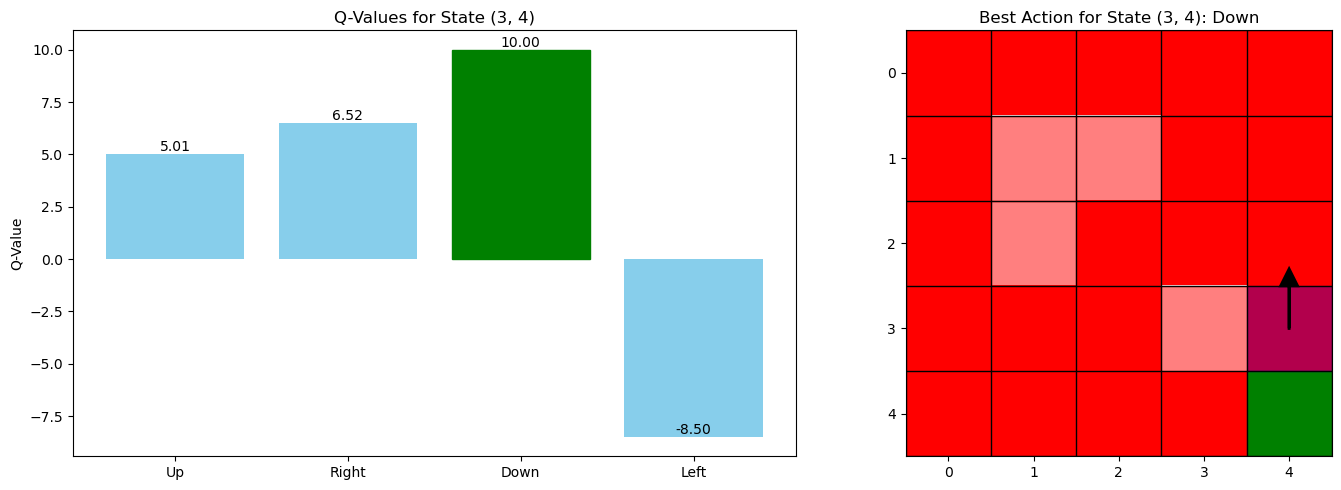

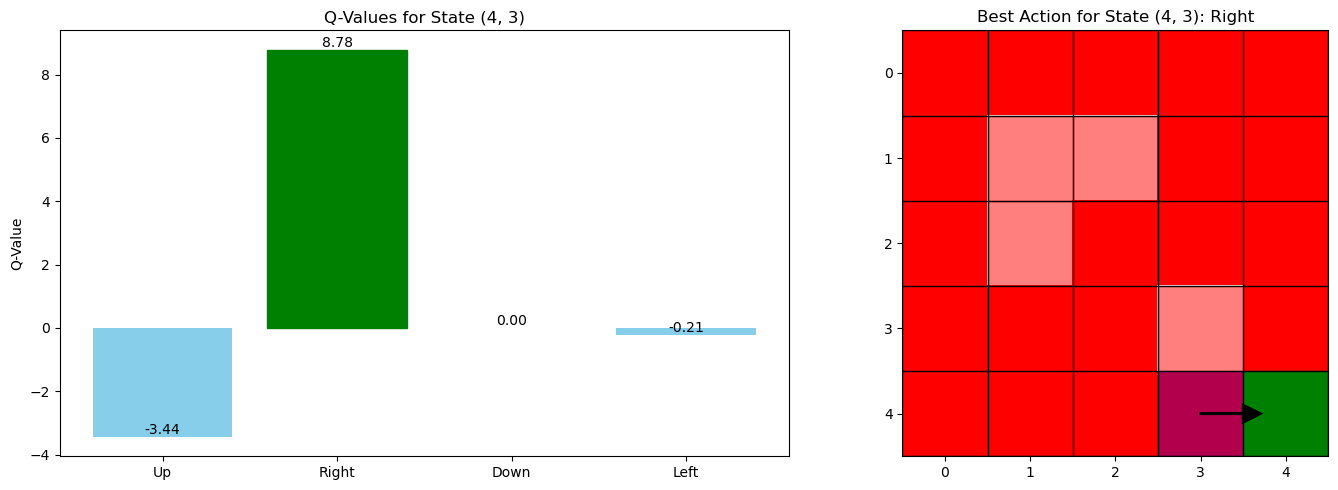

In [10]:
def visualize_state_qvalues(state, q_table, env):
    # Convert state to index
    row, col = state
    state_idx = row * env.width + col
    q_values = q_table[state_idx]
    
    # Action names
    action_names = ["Up", "Right", "Down", "Left"]
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar chart of Q-values
    bars = ax1.bar(action_names, q_values, color='skyblue')
    ax1.set_ylabel('Q-Value')
    ax1.set_title(f'Q-Values for State ({row}, {col})')
    
    # Highlight the best action
    best_action = np.argmax(q_values)
    bars[best_action].set_color('green')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    # Visualization of state in grid
    cmap = mcolors.ListedColormap(['white', 'red', 'green'])
    bounds = [-2, -0.5, 0.5, 11]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    ax2.imshow(env.grid, cmap=cmap, norm=norm)
    
    # Draw grid lines
    for i in range(env.width + 1):
        ax2.axvline(i - 0.5, color='black', linewidth=1)
    for i in range(env.height + 1):
        ax2.axhline(i - 0.5, color='black', linewidth=1)
    
    # Mark obstacles and goal
    for obs in env.obstacles:
        ax2.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1, fill=True, color='red', alpha=0.5))
    ax2.add_patch(Rectangle((env.goal_state[1] - 0.5, env.goal_state[0] - 0.5), 1, 1, fill=True, color='green', alpha=0.5))
    
    # Highlight current state
    ax2.add_patch(Rectangle((col - 0.5, row - 0.5), 1, 1, fill=True, color='blue', alpha=0.3))
    
    # Draw arrow for best action
    dx, dy = env.actions[best_action]
    # Flip for plotting
    dx, dy = dy, -dx
    ax2.arrow(col, row, dx * 0.5, dy * 0.5, head_width=0.2, head_length=0.2, fc='black', ec='black', linewidth=2)
    
    # Set labels and title
    ax2.set_xticks(np.arange(env.width))
    ax2.set_yticks(np.arange(env.height))
    ax2.set_xticklabels(np.arange(env.width))
    ax2.set_yticklabels(np.arange(env.height))
    ax2.set_title(f'Best Action for State ({row}, {col}): {action_names[best_action]}')
    
    plt.tight_layout()
    plt.show()

# Analyze Q-values for specific states
key_states = [(0, 0), (2, 2), (3, 4), (4, 3)]
for state in key_states:
    visualize_state_qvalues(state, agent.q_table, env)

## 11. Decision-Making Breakdown

Let's analyze a single step of the agent's decision-making process in detail.

In [11]:
def explain_decision(state, q_table, env):
    row, col = state
    state_idx = row * env.width + col
    q_values = q_table[state_idx]
    action_names = ["Up", "Right", "Down", "Left"]
    
    print(f"Decision Analysis for State ({row}, {col}):\n")
    print("Q-Values by Action:")
    for i, (action, q_val) in enumerate(zip(action_names, q_values)):
        # Calculate where this action would lead
        dx, dy = env.actions[i]
        new_row, new_col = row + dx, col + dy
        
        # Check if the action leads to a valid state
        if 0 <= new_row < env.height and 0 <= new_col < env.width:
            new_state = (new_row, new_col)
            # Determine what's in that state
            if new_state in env.obstacles:
                result = "obstacle (invalid move)"
            elif new_state == env.goal_state:
                result = "goal state"
            else:
                result = "valid space"
        else:
            result = "out of bounds (invalid move)"
            
        print(f"  - {action}: {q_val:.4f} → leads to ({new_row}, {new_col}): {result}")
    
    # Best action
    best_action_idx = np.argmax(q_values)
    best_action = action_names[best_action_idx]
    print(f"\nBest Action: {best_action} with Q-value of {q_values[best_action_idx]:.4f}")
    
    # Expected future rewards
    dx, dy = env.actions[best_action_idx]
    new_row, new_col = row + dx, col + dy
    if 0 <= new_row < env.height and 0 <= new_col < env.width:
        new_state_idx = new_row * env.width + new_col
        future_reward = np.max(q_table[new_state_idx])
        print(f"Expected best future reward from next state: {future_reward:.4f}")
    
    # Decision quality
    q_range = np.max(q_values) - np.min(q_values)
    if q_range > 5:
        confidence = "Very confident (large difference between best and worst actions)"
    elif q_range > 2:
        confidence = "Moderately confident"
    elif q_range > 0.5:
        confidence = "Somewhat confident"
    else:
        confidence = "Not confident (small difference between actions)"
    
    print(f"Decision Confidence: {confidence}")

# Analyze a few interesting states
states_to_explain = [(0, 0), (2, 2), (4, 3)]
for state in states_to_explain:
    explain_decision(state, agent.q_table, env)
    print("\n" + "-"*50 + "\n")

Decision Analysis for State (0, 0):

Q-Values by Action:
  - Up: -2.4365 → leads to (-1, 0): out of bounds (invalid move)
  - Right: -0.4341 → leads to (0, 1): valid space
  - Down: -3.7315 → leads to (1, 0): valid space
  - Left: -2.2927 → leads to (0, -1): out of bounds (invalid move)

Best Action: Right with Q-value of -0.4341
Expected best future reward from next state: 0.6288
Decision Confidence: Moderately confident

--------------------------------------------------

Decision Analysis for State (2, 2):

Q-Values by Action:
  - Up: -1.9000 → leads to (1, 2): obstacle (invalid move)
  - Right: -0.0431 → leads to (2, 3): valid space
  - Down: -0.5302 → leads to (3, 2): valid space
  - Left: -1.9000 → leads to (2, 1): obstacle (invalid move)

Best Action: Right with Q-value of -0.0431
Expected best future reward from next state: 5.9949
Decision Confidence: Somewhat confident

--------------------------------------------------

Decision Analysis for State (4, 3):

Q-Values by Action:

## 12. Experiment with Different Parameters

Let's examine how different parameters affect the agent's learning and movement.

Training with learning_rate=0.1, discount_factor=0.9
Training with learning_rate=0.1, discount_factor=0.99
Training with learning_rate=0.5, discount_factor=0.9
Training with learning_rate=0.5, discount_factor=0.99


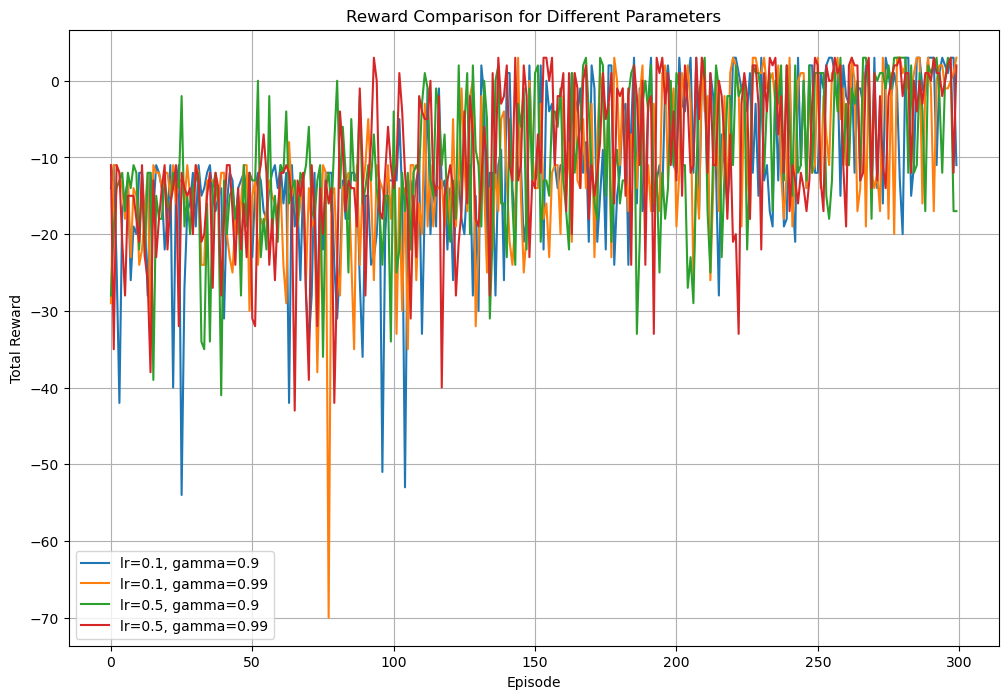

Average reward over last 100 episodes:
lr=0.1, gamma=0.9: -4.67
lr=0.1, gamma=0.99: -5.20
lr=0.5, gamma=0.9: -5.17
lr=0.5, gamma=0.99: -4.91


In [12]:
def compare_learning_parameters(learning_rates, discount_factors):
    results = {}
    
    for lr in learning_rates:
        for gamma in discount_factors:
            print(f"Training with learning_rate={lr}, discount_factor={gamma}")
            
            # Create environment and agent with these parameters
            test_env = GridWorldEnv(height=5, width=5)
            test_agent = QLearningAgent(n_states=test_env.n_states, n_actions=test_env.n_actions,
                                        learning_rate=lr, discount_factor=gamma)
            
            # Training parameters
            num_episodes = 300
            max_episode_steps = 100
            
            # Training loop
            episode_rewards = []
            
            for episode in range(num_episodes):
                state = test_env.reset()
                total_reward = 0
                done = False
                steps = 0
                
                while not done and steps < max_episode_steps:
                    action = test_agent.choose_action(state)
                    next_state, reward, done = test_env.step(action)
                    test_agent.update(state, action, reward, next_state, done)
                    
                    state = next_state
                    total_reward += reward
                    steps += 1
                
                test_agent.decay_exploration()
                episode_rewards.append(total_reward)
            
            # Store results
            key = f"lr={lr}, gamma={gamma}"
            results[key] = {
                'rewards': episode_rewards,
                'avg_last_100': np.mean(episode_rewards[-100:]),
                'q_table': test_agent.q_table.copy()
            }
    
    return results

# Define parameter values to test
learning_rates = [0.1, 0.5]
discount_factors = [0.9, 0.99]

# Run comparison
parameter_results = compare_learning_parameters(learning_rates, discount_factors)

# Visualize comparison
plt.figure(figsize=(12, 8))

for key, data in parameter_results.items():
    plt.plot(data['rewards'], label=key)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Comparison for Different Parameters')
plt.legend()
plt.grid(True)
plt.show()

# Print summary statistics
print("Average reward over last 100 episodes:")
for key, data in parameter_results.items():
    print(f"{key}: {data['avg_last_100']:.2f}")

## 13. Conclusion

In this notebook, we've implemented Q-learning and visualized the agent's movement in detail. Key observations include:

1. The agent initially explores randomly but gradually learns the optimal policy
2. The agent learns to avoid obstacles and find the shortest path to the goal
3. Different parameters can significantly affect learning performance
4. The Q-table provides insights into the agent's decision-making process

By visualizing each step, we've gained a better understanding of how Q-learning works in practice.